In [201]:
import numpy as np
import missingno as msno
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import is_string_dtype, is_numeric_dtype  
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import Counter
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime
import datetime as dt
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [202]:
%matplotlib inline 
rcParams['figure.figsize'] = 5,4 

In [203]:
df_inicial = pd.read_csv("datos_para_trabajo.csv")
print("Numero de registros y variables: " , df_inicial.shape)
df_inicial.head(3)

Numero de registros y variables:  (205, 24)


,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,lnprice
0,alfa-romero,gas,std,two,convertible,rwd,front,-1.690772,-0.426521,-0.844782,...,0.090345,mpfi,0.492718,-1.844656,-0.288349,0.179306,-0.270357,-0.646553,-0.546059,0.343992
1,alfa-romero,gas,std,two,convertible,rwd,front,-1.690772,-0.426521,-0.844782,...,0.090345,mpfi,0.492718,-1.844656,-0.288349,0.179306,-0.270357,-0.646553,-0.546059,0.741219
2,alfa-romero,gas,std,two,hatchback,rwd,front,-0.708596,-0.231513,-0.190566,...,0.646977,mpfi,-2.399480,0.675523,-0.288349,1.265619,-0.270357,-0.953012,-0.691627,0.741219


Datos faltantes
make                 0
fuel_type            0
aspiration           0
num_of_doors         0
body_style           0
drive_wheels         0
engine_location      0
wheel_base           0
length               0
width                0
height               0
curb_weight          0
engine_type          0
num_of_cylinders     0
engine_size          0
fuel_system          0
bore                 0
stroke               0
compression_ratio    0
horsepower           0
peak_rpm             0
city_mpg             0
highway_mpg          0
lnprice              0
dtype: int64


<AxesSubplot:>

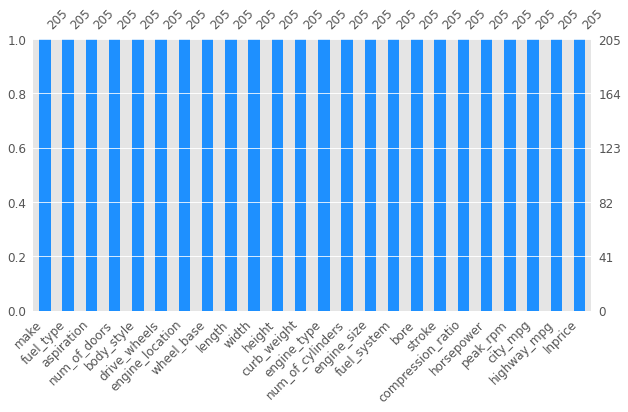

In [204]:
print("Datos faltantes")
print(df_inicial.isnull().sum())
plt.style.use('ggplot')
msno.bar(df_inicial, figsize=(10,5), color="dodgerblue", fontsize=12)

In [205]:
df_inicial.dtypes

make                  object
fuel_type             object
aspiration            object
num_of_doors          object
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight          float64
engine_type           object
num_of_cylinders      object
engine_size          float64
fuel_system           object
bore                 float64
stroke               float64
compression_ratio    float64
horsepower           float64
peak_rpm             float64
city_mpg             float64
highway_mpg          float64
lnprice              float64
dtype: object

In [206]:
## Separamos entre las variable numericas y categoricas
num_list = []
cat_list = []

for column in df_inicial:
    if is_numeric_dtype(df_inicial[column]):
        num_list.append(column)
    elif is_string_dtype(df_inicial[column]):
        cat_list.append(column)
print('Categoricas: ', cat_list)
print('Numericas: ', num_list)

Categoricas:  ['make', 'fuel_type', 'aspiration', 'num_of_doors', 'body_style', 'drive_wheels', 'engine_location', 'engine_type', 'num_of_cylinders', 'fuel_system']
Numericas:  ['wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'lnprice']


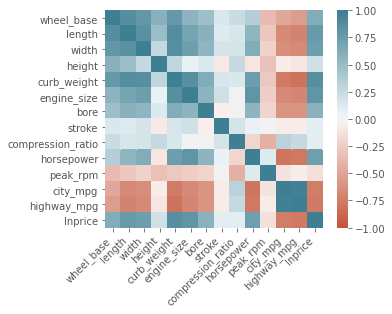

In [207]:
# sns.corrplot(df_inicial[num_list])

corr = df_inicial[num_list].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [208]:
# Se crea una nueva variable que pondere con el mismo porcentaje el consumo de combustible en ciudad y carretera
df_inicial['fuel_mpg'] = (0.50 * df_inicial['city_mpg']) + (0.50 * df_inicial['highway_mpg'])

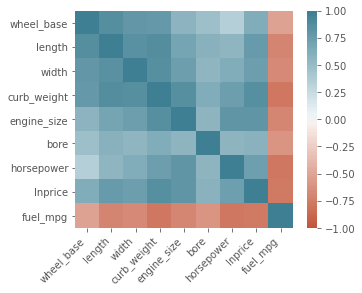

In [209]:
## Quitamos las variables menos correlacionadas con la variable objetivo
# stroke, compression_ratio
## Se retira tambien la variable highway-mpg ya que esta muy correlacionada con city-mpg
num_list.append('fuel_mpg')
num_list.remove('stroke')
num_list.remove('compression_ratio')
num_list.remove('height')
num_list.remove('peak_rpm')
num_list.remove('city_mpg')
num_list.remove('highway_mpg')

corr = df_inicial[num_list].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [210]:
corr

,wheel_base,length,width,curb_weight,engine_size,bore,horsepower,lnprice,fuel_mpg
wheel_base,1.000000,0.874587,0.795144,0.776386,0.576057,0.471522,0.354480,0.631025,-0.510922
length,0.874587,1.000000,0.841118,0.877728,0.694487,0.591369,0.548479,0.769842,-0.692767
width,0.795144,0.841118,1.000000,0.867032,0.742741,0.551066,0.636906,0.746479,-0.664742
curb_weight,0.776386,0.877728,0.867032,1.000000,0.863217,0.635681,0.748539,0.859842,-0.783071
engine_size,0.576057,0.694487,0.742741,0.863217,1.000000,0.563226,0.811824,0.813712,-0.681033
bore,0.471522,0.591369,0.551066,0.635681,0.563226,1.000000,0.565843,0.585912,-0.608919
horsepower,0.354480,0.548479,0.636906,0.748539,0.811824,0.565843,1.000000,0.733589,-0.788147
lnprice,0.631025,0.769842,0.746479,0.859842,0.813712,0.585912,0.733589,1.000000,-0.761520
fuel_mpg,-0.510922,-0.692767,-0.664742,-0.783071,-0.681033,-0.608919,-0.788147,-0.761520,1.000000


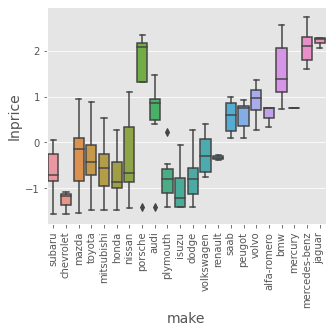

In [211]:
g = sns.boxplot(x='make',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('make',size=14);

In [212]:
Counter(df_inicial.make)

Counter({'alfa-romero': 3,
         'audi': 7,
         'bmw': 8,
         'chevrolet': 3,
         'dodge': 9,
         'honda': 13,
         'isuzu': 4,
         'jaguar': 3,
         'mazda': 17,
         'mercedes-benz': 8,
         'mercury': 1,
         'mitsubishi': 13,
         'nissan': 18,
         'peugot': 11,
         'plymouth': 7,
         'porsche': 5,
         'renault': 2,
         'saab': 6,
         'subaru': 12,
         'toyota': 32,
         'volkswagen': 12,
         'volvo': 11})

count    2.050000e+02
mean    -2.439024e-11
std      1.002448e+00
min     -1.571703e+00
25%     -7.674789e-01
50%     -2.094975e-01
75%      7.412192e-01
max      2.741078e+00
Name: lnprice, dtype: float64

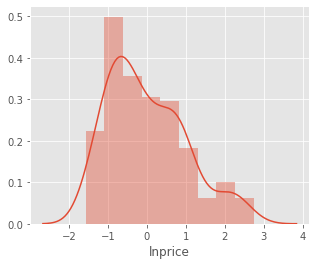

In [213]:
sns.distplot(df_inicial['lnprice'])
df_inicial['lnprice'].describe()

In [214]:
### Dado que hay un conteo muy pequeño de autos en una marca, se pueden agrupar, ademas se observa en la
#grafica que  un grupo de autos tienen mayor precio.

# cars['price'] = cars['price'].astype('int')
temp = df_inicial.copy()
table = df_inicial.groupby(['make'])['lnprice'].mean()
temp = temp.merge(table.reset_index(), how='left',on='make')
bins = [-2,-0.5,1,3]
cars_bin=['economico','medio','costoso']
df_inicial['price_range'] = pd.cut(temp['lnprice_y'],bins,right=False,labels=cars_bin)
df_inicial.head()

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,lnprice,fuel_mpg,price_range
0,alfa-romero,gas,std,two,convertible,rwd,front,-1.690772,-0.426521,-0.844782,...,0.492718,-1.844656,-0.288349,0.179306,-0.270357,-0.646553,-0.546059,0.343992,-0.596306,medio
1,alfa-romero,gas,std,two,convertible,rwd,front,-1.690772,-0.426521,-0.844782,...,0.492718,-1.844656,-0.288349,0.179306,-0.270357,-0.646553,-0.546059,0.741219,-0.596306,medio
2,alfa-romero,gas,std,two,hatchback,rwd,front,-0.708596,-0.231513,-0.190566,...,-2.399480,0.675523,-0.288349,1.265619,-0.270357,-0.953012,-0.691627,0.741219,-0.822319,medio
3,audi,gas,std,four,sedan,fwd,front,0.173698,0.207256,0.136542,...,-0.532364,0.452216,-0.035973,-0.048061,0.777340,-0.186865,-0.109354,0.409512,-0.148109,medio
4,audi,gas,std,four,sedan,4wd,front,0.107110,0.207256,0.230001,...,-0.532364,0.452216,-0.540725,0.280359,0.777340,-1.106241,-1.273900,0.851826,-1.190071,medio


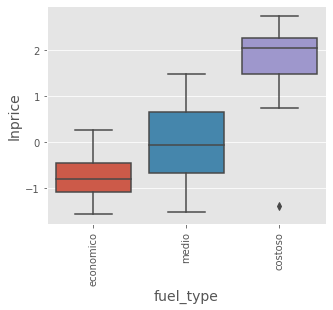

In [215]:
g = sns.boxplot(x='price_range',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('fuel_type',size=14);

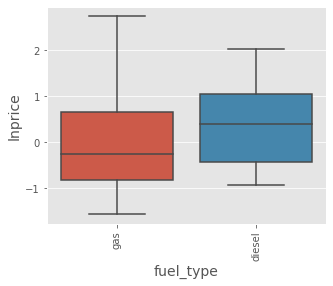

In [216]:
g = sns.boxplot(x='fuel_type',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('fuel_type',size=14);

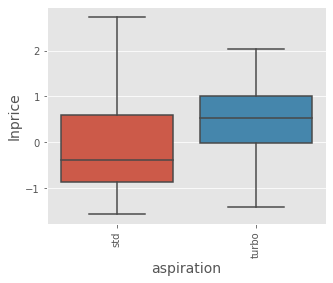

In [217]:
g = sns.boxplot(x='aspiration',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('aspiration',size=14);

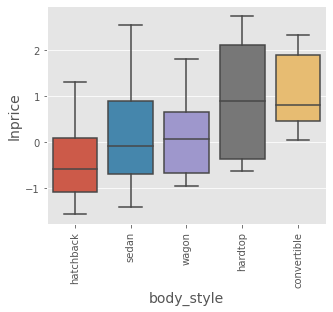

In [218]:
#  'num_of_doors'

# Se quita numero de puertas engine_type
g = sns.boxplot(x='body_style',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('body_style',size=14);

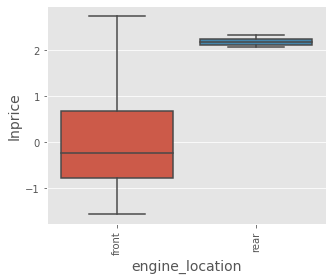

In [219]:
# ,  'drive_wheels'

g = sns.boxplot(x='engine_location',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('engine_location',size=14);

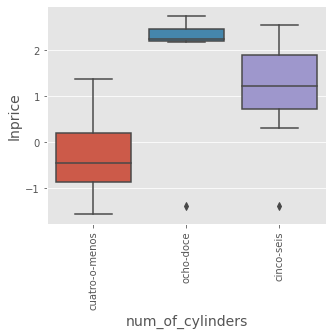

In [220]:
#, 'engine_type'
g = sns.boxplot(x='num_of_cylinders',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('num_of_cylinders',size=14);

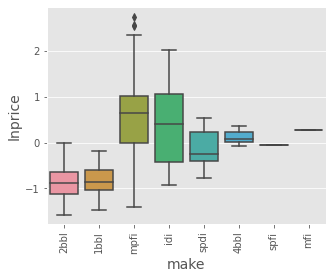

In [221]:
g = sns.boxplot(x='fuel_system',y='lnprice',data=df_inicial.sort_values(by=['lnprice']))
g.set_ylabel('lnprice',size=14)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)
g.set_xlabel('make',size=14);

In [222]:
## Variables finales
df_inicial.drop(['city_mpg','highway_mpg','engine_type','drive_wheels','num_of_doors','stroke','compression_ratio','height','peak_rpm', 'make'], axis=1, inplace=True)

In [225]:
df_inicial.columns

Index(['fuel_type', 'aspiration', 'body_style', 'engine_location',
       'wheel_base', 'length', 'width', 'curb_weight', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore', 'horsepower', 'lnprice',
       'fuel_mpg', 'price_range'],
      dtype='object')

In [226]:
df_modelo = df_inicial[['fuel_type', 'aspiration', 'body_style', 'engine_location',
       'wheel_base', 'length', 'width', 'curb_weight', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore', 'horsepower',
       'fuel_mpg', 'price_range', 'lnprice']]
print("Numero de filas y variables final: " , df_modelo.shape)
df_modelo.head(5)

Numero de filas y variables final:  (205, 16)


,fuel_type,aspiration,body_style,engine_location,wheel_base,length,width,curb_weight,num_of_cylinders,engine_size,fuel_system,bore,horsepower,fuel_mpg,price_range,lnprice
0,gas,std,convertible,front,-1.690772,-0.426521,-0.844782,-0.014566,cuatro-o-menos,0.090345,mpfi,0.492718,0.179306,-0.596306,medio,0.343992
1,gas,std,convertible,front,-1.690772,-0.426521,-0.844782,-0.014566,cuatro-o-menos,0.090345,mpfi,0.492718,0.179306,-0.596306,medio,0.741219
2,gas,std,hatchback,front,-0.708596,-0.231513,-0.190566,0.514882,cinco-seis,0.646977,mpfi,-2.399480,1.265619,-0.822319,medio,0.741219
3,gas,std,sedan,front,0.173698,0.207256,0.136542,-0.420797,cuatro-o-menos,-0.440986,mpfi,-0.532364,-0.048061,-0.148109,medio,0.409512
4,gas,std,sedan,front,0.107110,0.207256,0.230001,0.516807,cinco-seis,0.242154,mpfi,-0.532364,0.280359,-1.190071,medio,0.851826


In [224]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

In [227]:
# Defining the map function
def dummies(x,df):
    temp = pd.get_dummies(df[x], drop_first = True)
    df = pd.concat([df, temp], axis = 1)
    df.drop([x], axis = 1, inplace = True)
    return df

df_modelo = dummies('fuel_type',df_modelo)
df_modelo = dummies('aspiration',df_modelo)
df_modelo = dummies('body_style',df_modelo)
df_modelo = dummies('engine_location',df_modelo)
df_modelo = dummies('num_of_cylinders',df_modelo)
df_modelo = dummies('fuel_system',df_modelo)
df_modelo = dummies('price_range',df_modelo)

df_modelo.head(3)

,wheel_base,length,width,curb_weight,engine_size,bore,horsepower,fuel_mpg,lnprice,gas,...,ocho-doce,2bbl,4bbl,idi,mfi,mpfi,spdi,spfi,medio,costoso
0,-1.690772,-0.426521,-0.844782,-0.014566,0.090345,0.492718,0.179306,-0.596306,0.343992,1,...,0,0,0,0,0,1,0,0,1,0
1,-1.690772,-0.426521,-0.844782,-0.014566,0.090345,0.492718,0.179306,-0.596306,0.741219,1,...,0,0,0,0,0,1,0,0,1,0
2,-0.708596,-0.231513,-0.190566,0.514882,0.646977,-2.399480,1.265619,-0.822319,0.741219,1,...,0,0,0,0,0,1,0,0,1,0
